# Bayesian estimation for paired data

This notebook illustrates how to do Bayesian Estimation of the difference between two paired sets of data. The data are not necessarily normally distributed, but their difference is. This is inspired by a paper by <a href="http://www.indiana.edu/~kruschke/BEST/">John K. Kruschke: "Bayesian estimation supersedes the t test"</a> and his excellent <a href="https://sites.google.com/site/doingbayesiandataanalysis/1st-ed-stuff">book</a> on the subject.

To do Markov-Chain Monte Carlo sampling in Python we use <a href="https://pymc-devs.github.io/pymc/">the PyMC package</a>.

In [1]:
%matplotlib inline
from __future__ import division
import pymc as pymc
import numpy as np
from bestplot import plot_posterior, plot_data_and_prediction, plot_data
import matplotlib.pyplot as plt
from IPython.display import display, HTML

display(HTML(open('Notebook.css').read()))  #load the CCS style sheet

First let's load some data. This data is for 4 different configurations of a three layer neural network (see below), each tested 100 times. There is a random component to each of the 100 tests - the weights from the input layer to the hidden layer of neurons - but this component is identical for all 4 configurations. Thus the data are paired.

The 4 neural networks were trained and tested on the MNIST hand writted digit database and each of the 10 output neurons was trained to respond to one of the digits 0-9 with a value of 1, and with a value of 0 to all other digits. The MNIST database consists of a standard set of 60,000 training digits and 10,000 testing digits. The images are all 8-bit grey-scale, 28 x 28 pixels large. 

The data for each of the 4 configurations are lists of errors on the 10,000 test patterns. Configuration 1 uses the original grey-scale image, and configuration 2 uses binary versions of these images, where all values larger than 0 are set to 1. Both of these configurations use a sigmoidal function, $tanh$, as the nonlinear tranfer function of the hidden neurons, as is typically done in the field. Configuration 3 replaces this nonlinearity with a broken stick nonlinarity and uses the black-and-white input images. Finally, configuration 4 is identical to configuration 3, except that the output weights are converted from 64-bit floating point numbers to 6-bit fixed point numbers.

More details can be found in *(reference our paper when published)*.

![](MNIST-NEF.png)

In [2]:
# read data into 2d array
my_data = np.genfromtxt('errors.txt', delimiter=',')
my_data=my_data[:,1:]*1e4

# read headers into array
my_headers = np.genfromtxt('errors.txt', delimiter=',', dtype=None)
h=[]
for i in range(my_headers.size):
    h = np.append(h,my_headers[i][0])


Now, let's have a look at the four distributions:

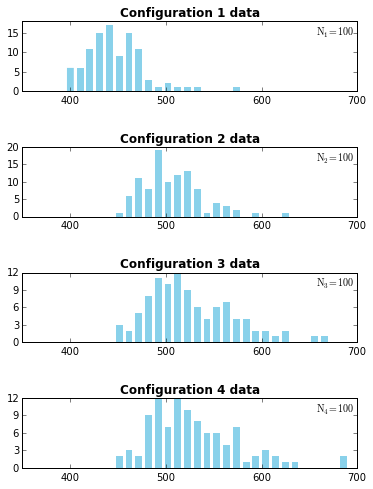

In [3]:
n_bins = 30
bins = np.linspace(my_data.min(), my_data.max(), n_bins)
plt.figure(figsize = (6, 8), facecolor = 'white')
for i in range(4):
    ax = plt.subplot(4,1,i+1)
    plot_data(my_data[i], ax, bins = bins, group = i+1, name = h[i])
plt.subplots_adjust(hspace=0.8)

These errors clearly don't look like they are normally distributed, with a larger tail towards the higher values than towards the lower values. Fortunately, we are in this case interested in the differences going from Configuration 1, to 2, to 3, to 4. When we plot these differences, we get:

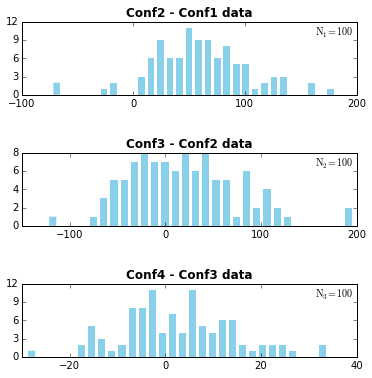

In [4]:
plt.figure(figsize = (6, 6), facecolor = 'white')
my_diffs = np.zeros((my_data.shape[0]-1, my_data.shape[1]))
for i in range(3):
    my_diffs[i] = my_data[i+1] -  my_data[i]
    ax = plt.subplot(3,1,i+1)    
    plot_data(my_diffs[i], ax, bins = n_bins, group = i+1, name = 'Conf%d - Conf%d'%(i+2,i+1))
plt.subplots_adjust(hspace=0.8)

These distributions look much more symmetrical and look like they will be well modelled by a t-distribution. This distribution is characterised by a mean, $\mu$, a standard deviation, $\sigma$, and a normality parameter, $\nu$. The normality parameter makes the distribution more Normal if $\nu$ is large (over 30), and gives it bigger tails if $\nu$ gets closer to 1.

Since we do not know what the parameters are for each of the two data distributions, we need to estimate them from the data. To do this in a Bayesian framework, we will need to provide prior distributions that describe our beliefs about these parameters. This leads us to the following hierarchical model in which we estimate the distribution independently for each of the three distributions of differences shown above:

![](t-dist.png)

The distribution for $\mu$ is a normal distribution with a mean equal to the mean of the data, and a standard deviation 1000 times larger than that of the  data. Let's look at the first distribution of paired differences first:

In [5]:
diff_dist = 0                       # select which difference distribution to look at.
y = my_diffs[diff_dist]             # first distribution of differences
mu_m = np.mean(y)                   # mean of distribution of group means
mu_p = 1/(1000*np.std(y))**2        # precision of distribution of group means

The standard deviation, $\sigma$, of the data is modelled by a uniform distribution where all values between one thousands of the standard deviation of the data to one thousand times the standard deviation of the data are equally likely. This large range expresses that we are not very certain about the value $\sigma$:

In [6]:
sigma_low = np.std(y)/1000          # lower bound is 1000 times less than std of data
sigma_high = np.std(y)*1000         # upper bound is 1000 times more than std of data

Once these hyperparameters are chosen, we can define our prior distributions for the parameters of our model:

In [7]:
group_mean = pymc.Normal('group_mean', mu_m, mu_p)
group_std = pymc.Uniform('group_std', sigma_low, sigma_high)
nu_minus_one = pymc.Exponential('nu_minus_one', 1/29)

To use these randomly sampled parameters to describe a t-distribution that fits the data, we need to modify the random variables in a deterministic manner. Our prior distribution actually specifies $\nu - 1$, so we need to add $1$, and the standard deviations need to be converted to a rate, $\lambda = 1/\sigma^2$:

In [8]:
# Normality nu = nu_minus_one + 1 
@pymc.deterministic(plot = False)
def nu(n = nu_minus_one):  
    out = n+1
    return out

# Scale lam = 1/std**2
@pymc.deterministic(plot=False)
def lam(s = group_std):
    out = 1/s**2
    return out


Now we are finally ready to define the data distributions - the lowest part in the hierarchy:

In [9]:
group = pymc.NoncentralT('group', group_mean, lam, nu, value = y, observed = True)

With all the distributions in the hierarchy defined, we can collect them in a PyMC Model, and initialise it for MCMC sampling:

In [10]:
model = pymc.Model({group, group_mean, group_std, nu_minus_one})

# Define the MCMC object on the model
M = pymc.MCMC(model)

Now we can sample from the MCMC object using a Markov chain that is 'iter' long. The first 'burn' samples from this chain are discarded. Every 'thin'th sample from the remainder is kept and the rest discarded.

In [11]:
M.sample(iter = 110000, burn = 10000, thin = 1) 

 [-----------------100%-----------------] 110000 of 110000 complete in 14.2 sec

After running this, our estimation is done. We now get the estimated mean and standard deviation for the distribution of paired differences. 

We define 4 subplots that we plot using the routines provided in the bestplot.py file.

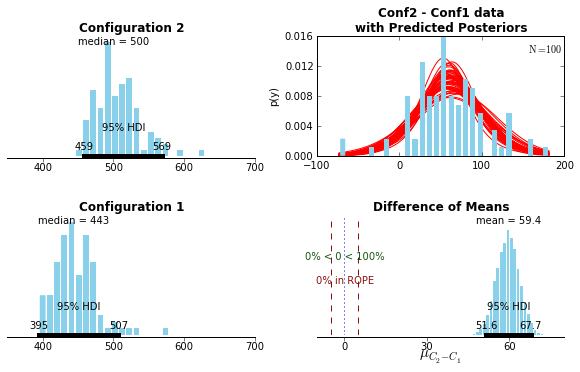

In [12]:
# Create a figure to hold 2 rows and 2 columns
f = plt.figure(figsize = (9,5), facecolor = 'white')

# Left column: plot the original distributions of the data
ax1 = f.add_subplot(2, 2, 1, axisbg = 'none')
plot_posterior( my_data[diff_dist+1], 
                ax = ax1, 
                bins = bins, 
                title = h[diff_dist+1],
                label = '',
                ctd = 'median', 
                printstats = False
              )

ax3 = f.add_subplot(2, 2, 3, axisbg = 'none')
plot_posterior( my_data[diff_dist], 
                ax = ax3, 
                bins = bins,
                title = h[diff_dist], 
                label = '',
                ctd = 'median', 
                printstats = False
              )

# Right column, top panel: plot histogram of data differences 
# and 50 of the t-distribution fits from the MCMC chain
orig_vals = M.get_node('group').value
bin_edges = np.linspace( np.min(orig_vals), np.max(orig_vals), n_bins )
ax2 = f.add_subplot(2, 2, 2, axisbg = 'none')
plot_data_and_prediction( M.get_node('group').value, 
                          M.trace('group_mean')[:], 
                          M.trace('group_std')[:],
                          M.trace('nu_minus_one')[:], 
                          ax2, 
                          bins = bin_edges, 
                          group = '', 
                          name = 'Conf%d - Conf%d'%(diff_dist+2, diff_dist+1), 
                          colour = 'blue'
                        )

# Right column, bottom panel: plot the posterior distribution for the mean difference
ax4 = f.add_subplot(2, 2, 4, axisbg = 'none')
plot_posterior( M.trace('group_mean')[:], 
                ax = ax4, 
                bins = n_bins,
                title = 'Difference of Means',
                label = r'$\mu_{C_%d-C_%d}$'%(diff_dist+2, diff_dist+1),
                ctd = 'mean', 
                draw_zero = True,
                compVal = 0.0,
                ROPE = [-5, 5], 
                printstats = False
              )

f.subplots_adjust(hspace = 0.5, top = 0.92, bottom = 0.09,
                  left = 0.09, right = 0.95, wspace = 0.25)


The result of our Bayesian Estimation indicates that going from grey-scale input images to black-and-white images results in somewhere between 52 to 68 more errors out of the 10,000 test patterns, indicating an increase in error rate of 0.6%. We consider a change in number of errors of 5 or less as effectively no change at all, i.e., it forms a region of practical equivalence (ROPE). The whole distribution for the difference of means lies outside the ROPE, and we conclude with certainty that the change to black-and-white images increases the number of errors made.

We can repeat the procedure to look at the second paired difference, where we change the nonlinearity in the hidden layer neurons:

 [-----------------100%-----------------] 110000 of 110000 complete in 13.9 sec

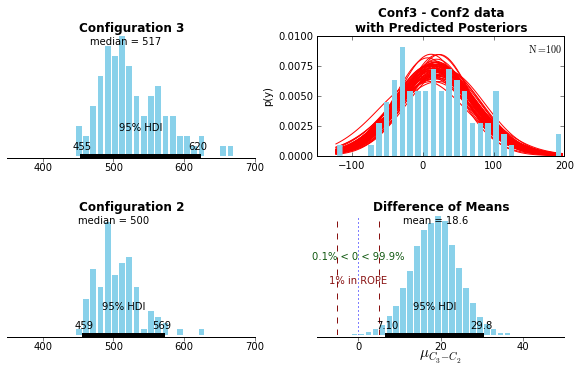

In [13]:
# before running the next estimation, we need to reset the following pymc objects

%reset_selective -f group*
%reset_selective -f nu_minus_one
%reset_selective -f model

diff_dist = 1                       # select which difference distribution to look at.
y = my_diffs[diff_dist]             # get distribution of differences
mu_m = np.mean(y)                   # mean of distribution of group means
mu_p = 1/(1000*np.std(y))**2        # precision of distribution of group meanssigma_low = np.std(y)/1000          # lower bound is 1000 times less than std of data
sigma_high = np.std(y)*1000         # upper bound is 1000 times more than std of data

group_mean = pymc.Normal('group_mean', mu_m, mu_p)
group_std = pymc.Uniform('group_std', sigma_low, sigma_high)
nu_minus_one = pymc.Exponential('nu_minus_one', 1/29)

# Normality nu = nu_minus_one + 1 
@pymc.deterministic(plot = False)
def nu(n = nu_minus_one):  
    out = n+1
    return out

# Scale lam = 1/std**2
@pymc.deterministic(plot=False)
def lam(s = group_std):
    out = 1/s**2
    return out

group = pymc.NoncentralT('group', group_mean, lam, nu, value = y, observed = True)

model = pymc.Model({group, group_mean, group_std, nu_minus_one})

# Define the MCMC object on the model
M = pymc.MCMC(model)

M.sample(iter = 110000, burn = 10000, thin = 1) 

# Create a figure to hold 2 rows and 2 columns
f = plt.figure(figsize = (9,5), facecolor = 'white')

# Left column: plot the original distributions of the data
ax1 = f.add_subplot(2, 2, 1, axisbg = 'none')
plot_posterior( my_data[diff_dist+1], 
                ax = ax1, 
                bins = bins, 
                title = h[diff_dist+1],
                label = '',
                ctd = 'median', 
                printstats = False
              )

ax3 = f.add_subplot(2, 2, 3, axisbg = 'none')
plot_posterior( my_data[diff_dist], 
                ax = ax3, 
                bins = bins,
                title = h[diff_dist], 
                label = '',
                ctd = 'median', 
                printstats = False
              )

# Right column, top panel: plot histogram of data differences 
# and 50 of the t-distribution fits from the MCMC chain
orig_vals = M.get_node('group').value
bin_edges = np.linspace( np.min(orig_vals), np.max(orig_vals), n_bins )
ax2 = f.add_subplot(2, 2, 2, axisbg = 'none')
plot_data_and_prediction( M.get_node('group').value, 
                          M.trace('group_mean')[:], 
                          M.trace('group_std')[:],
                          M.trace('nu_minus_one')[:], 
                          ax2, 
                          bins = bin_edges, 
                          group = '', 
                          name = 'Conf%d - Conf%d'%(diff_dist+2, diff_dist+1), 
                          colour = 'blue'
                        )

# Right column, bottom panel: plot the posterior distribution for the mean difference
ax4 = f.add_subplot(2, 2, 4, axisbg = 'none')
plot_posterior( M.trace('group_mean')[:], 
                ax = ax4, 
                bins = n_bins,
                title = 'Difference of Means',
                label = r'$\mu_{C_%d-C_%d}$'%(diff_dist+2, diff_dist+1),
                ctd = 'mean', 
                draw_zero = True,
                compVal = 0.0,
                ROPE = [-5, 5], 
                printstats = False
              )

f.subplots_adjust(hspace = 0.5, top = 0.92, bottom = 0.09,
                  left = 0.09, right = 0.95, wspace = 0.25)

In this case, the change of the nonlinear transfer function of the hidden layer neuron results in between 10 and 30 more errors. All of the 95% Highest Density Interval lies outside the ROPE and only 1% of the posterior distribution for the difference of means lies inside the ROPE. Thus we are quite confident that the new type of non-linearity performs a little worse (about 0.2%).

And finally the third set of paired differences - going from 64-bit floating-point weights to 6-bit fixed-point weights:

 [-----------------100%-----------------] 110000 of 110000 complete in 13.9 sec

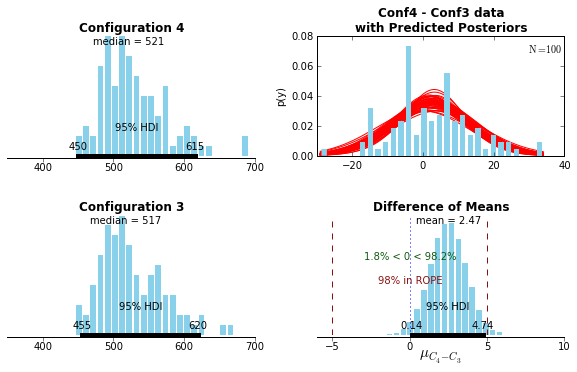

In [14]:
# before running the next estimation, we need to reset the following pymc objects

%reset_selective -f group*
%reset_selective -f nu_minus_one
%reset_selective -f model

diff_dist = 2                       # select which difference distribution to look at.
y = my_diffs[diff_dist]             # get distribution of differences
mu_m = np.mean(y)                   # mean of distribution of group means
mu_p = 1/(1000*np.std(y))**2        # precision of distribution of group meanssigma_low = np.std(y)/1000          # lower bound is 1000 times less than std of data
sigma_high = np.std(y)*1000         # upper bound is 1000 times more than std of data

group_mean = pymc.Normal('group_mean', mu_m, mu_p)
group_std = pymc.Uniform('group_std', sigma_low, sigma_high)
nu_minus_one = pymc.Exponential('nu_minus_one', 1/29)

# Normality nu = nu_minus_one + 1 
@pymc.deterministic(plot = False)
def nu(n = nu_minus_one):  
    out = n+1
    return out

# Scale lam = 1/std**2
@pymc.deterministic(plot=False)
def lam(s = group_std):
    out = 1/s**2
    return out

group = pymc.NoncentralT('group', group_mean, lam, nu, value = y, observed = True)

model = pymc.Model({group, group_mean, group_std, nu_minus_one})

# Define the MCMC object on the model
M = pymc.MCMC(model)

M.sample(iter = 110000, burn = 10000, thin = 1) 

# Create a figure to hold 2 rows and 2 columns
f = plt.figure(figsize = (9,5), facecolor = 'white')

# Left column: plot the original distributions of the data
ax1 = f.add_subplot(2, 2, 1, axisbg = 'none')
plot_posterior( my_data[diff_dist+1], 
                ax = ax1, 
                bins = bins, 
                title = h[diff_dist+1],
                label = '',
                ctd = 'median', 
                printstats = False
              )

ax3 = f.add_subplot(2, 2, 3, axisbg = 'none')
plot_posterior( my_data[diff_dist], 
                ax = ax3, 
                bins = bins,
                title = h[diff_dist], 
                label = '',
                ctd = 'median', 
                printstats = False
              )

# Right column, top panel: plot histogram of data differences 
# and 50 of the t-distribution fits from the MCMC chain
orig_vals = M.get_node('group').value
bin_edges = np.linspace( np.min(orig_vals), np.max(orig_vals), n_bins )
ax2 = f.add_subplot(2, 2, 2, axisbg = 'none')
plot_data_and_prediction( M.get_node('group').value, 
                          M.trace('group_mean')[:], 
                          M.trace('group_std')[:],
                          M.trace('nu_minus_one')[:], 
                          ax2, 
                          bins = bin_edges, 
                          group = '', 
                          name = 'Conf%d - Conf%d'%(diff_dist+2, diff_dist+1), 
                          colour = 'blue'
                        )

# Right column, bottom panel: plot the posterior distribution for the mean difference
ax4 = f.add_subplot(2, 2, 4, axisbg = 'none')
plot_posterior( M.trace('group_mean')[:], 
                ax = ax4, 
                bins = n_bins,
                title = 'Difference of Means',
                label = r'$\mu_{C_%d-C_%d}$'%(diff_dist+2, diff_dist+1),
                ctd = 'mean', 
                draw_zero = True,
                compVal = 0.0,
                ROPE = [-5, 5], 
                printstats = False
              )

f.subplots_adjust(hspace = 0.5, top = 0.92, bottom = 0.09,
                  left = 0.09, right = 0.95, wspace = 0.25)

Somewhat surpisingly, we find that 98% of the posterior distribution of the difference of means lies inside the ROPE, and all of the 95% HDI lies in it. Therefore, we can quite confidently conclude that the large reduction in the resolution of the output weights has practically no effect on the performance of the network.